In [5]:
# Source: https://medium.com/analytics-vidhya/recommendation-system-using-collaborative-filtering-cc310e641fde

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import cross_validate
from surprise import SVD

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data',  sep='\t', names=r_cols,
encoding='latin-1')
ratings.head()
i_cols = ['movie_id', 'title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('ml-100k/u.item',  sep='|', names=i_cols, encoding='latin-1')
movies.head()
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
encoding='latin-1')
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [9]:
#Assign X as the original ratings dataframe and y as the user_id column of ratings.
X = ratings.copy()
y = ratings['user_id']
#Split into training and test datasets, stratified along user_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y,random_state=42)

In [10]:
X_train.head()

,user_id,movie_id,rating,timestamp
94871,889,684,2,880180376
45252,135,203,4,879857797
90833,774,674,2,888557683
1570,161,98,4,891171357
46935,506,578,3,885135881


In [11]:
df_ratings = X_train.pivot(index='user_id', columns='movie_id', values='rating')

In [13]:
df_ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1669,1670,1671,1673,1674,1675,1676,1679,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_ratings_dummy = df_ratings.copy().fillna(0)
df_ratings_dummy.head()

#cosine similarity of the ratings
similarity_matrix = cosine_similarity(df_ratings_dummy, df_ratings_dummy)
similarity_matrix_df = pd.DataFrame(similarity_matrix, index=df_ratings.index, columns=df_ratings.index)
#calculate ratings using weighted sum of cosine similarity
#function to calculate ratings

def calculate_ratings(id_movie, id_user):
    if id_movie in df_ratings:
        cosine_scores = similarity_matrix_df[id_user] #similarity of id_user with every other user
        ratings_scores = df_ratings[id_movie]      #ratings of every other user for the movie id_movie
        #won't consider users who havent rated id_movie so drop similarity scores and ratings corresponsing to np.nan
        index_not_rated = ratings_scores[ratings_scores.isnull()].index
        ratings_scores = ratings_scores.dropna()
        cosine_scores = cosine_scores.drop(index_not_rated)
        ratings_movie = np.dot(ratings_scores, cosine_scores)/cosine_scores.sum()
    else:
        return 2.5
    return ratings_movie

In [16]:
calculate_ratings(3,150) #predicts rating for user_id 150 and movie_id 3

2.992640921879571

In [19]:
def score_on_test_set():
    user_movie_pairs = zip(X_test['movie_id'], X_test['user_id'])
    predicted_ratings = np.array([calculate_ratings(movie, user) for (movie,user) in user_movie_pairs])
    true_ratings = np.array(X_test['rating'])
    score = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    return score


In [20]:
test_set_score = score_on_test_set()
print(test_set_score)

1.0172812824757378


In [22]:
ratings = ratings.drop(columns='timestamp')
reader = Reader()

In [23]:
data = Dataset.load_from_df(ratings, reader)

In [25]:
knn = KNNBasic()
#Evaluating the performance in terms of RMSE
cross_validate(knn, data, measures=['RMSE', 'mae'], cv = 3)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.99534595, 0.98967781, 0.98314695]),
 'test_mae': array([0.78635298, 0.78138899, 0.77937173]),
 'fit_time': (0.21518683433532715, 0.21919846534729004, 0.2252044677734375),
 'test_time': (3.7133727073669434, 3.9711122512817383, 3.825474977493286)}

In [26]:
#Define the SVD algorithm object
svd = SVD()
#Evaluate the performance in terms of RMSE
cross_validate(svd, data, measures=['RMSE'], cv = 3)

{'test_rmse': array([0.94958505, 0.94137546, 0.94674985]),
 'fit_time': (2.699955701828003, 2.7194700241088867, 2.701453447341919),
 'test_time': (0.1631488800048828, 0.31028151512145996, 0.16214799880981445)}

In [27]:
trainset = data.build_full_trainset()
svd.fit(trainset)
ratings[ratings['user_id'] == 5]

,user_id,movie_id,rating
172,5,2,3
439,5,17,4
673,5,439,1
679,5,225,2
922,5,110,1
...,...,...,...
93172,5,419,3
94436,5,375,3
95021,5,373,3
96918,5,368,1


In [37]:
rating_predicted = svd.predict(3, 150)[3]


In [38]:
X_test.head()

,user_id,movie_id,rating,timestamp
33745,237,489,4,879376381
93837,535,156,2,879617613
19779,176,303,3,886047118
76325,83,756,4,883867791
10309,232,204,4,888549515


In [40]:
y_test

33745    237
93837    535
19779    176
76325     83
10309    232
        ... 
82918    747
86390    758
34211    198
73488    870
1828     234
Name: user_id, Length: 25000, dtype: int64

In [99]:
v1 = [svd.predict(1, i)[3] for i in range(len(df_ratings.columns))]
v2 = [svd.predict(3, i)[3] for i in range(len(df_ratings.columns))]
v3 = [svd.predict(5, i)[3] for i in range(len(df_ratings.columns))]

In [113]:
v1 = list()
v2 = list()
v3 = list()
for i in range(1,len(df_ratings.columns)):
    try:
        v2.append(calculate_ratings(1,i))
        v1.append(svd.predict(1, i)[3])
        v3.append(calculate_ratings(2,i))
    except:
        continue

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline

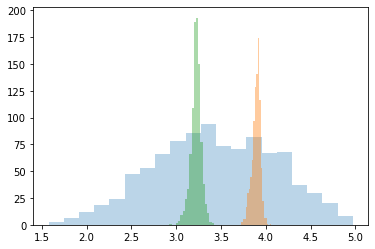

In [115]:
plt.hist(v1,bins=20,alpha=0.3)
plt.hist(v2,bins=20,alpha=0.4)
plt.hist(v3,bins=20,alpha=0.4);